# Estimating effect of tau on R0


In [1]:
import numpy as np
from numpy import exp, abs, log, floor,sqrt
import matplotlib.pyplot as plt
from scipy.integrate import quad
from functools import reduce
from operator import mul
def prod(L): return reduce(mul,L)

#I need a function with compact support, and choosing a differentiable seemed nice
#this is the simplest I could think of; it is not otherwise motivated for the
#distributions that I need it for.
def compact_support_function(min=0,max=1,shape=1,skew=1,scale=1):
    """Returns an infinitely differentiable function with compact support
    
    Returns an appropriate transform of exp(1/(x(x-1))).
    Parameters:
      [min,max] : interval on which function is non-zero
      shape     : (>0) larger values make the peak sharper
      skew      : (>0) Values <1 mean skew to left, values >1 mean skew to right
      scale     : maximum value.
    """
    interval_length=max-min
    scale=scale/exp(-4*shape)
    def f(x):
        t=(x-min)/interval_length
        if 0<t<1:
            ts=t**skew
            return scale*exp(shape/ts/(ts-1))
        else:
            return 0
    return f

class simulation:
    def __init__(self,N,beta_dist,q_dist,I0,policy,S0=1.0,time_scale=1.0):
        
        #conversion between real time and discrete time step number
        self.N = N
        Tfactor = N/time_scale
        self.Tfactor = Tfactor
        
        #discretize distributions
        beta=[quad(beta_dist,i/Tfactor,(i+1)/Tfactor)[0] for i in range(N)]
        symptom_onset_prop=[quad(q_dist,i/Tfactor,(i+1)/Tfactor)[0] for i in range(N)]
        q=[]
        symptomatic_prop=[]
        running_total=0
        for i in range(N):
            q.append(symptom_onset_prop[i]/(1-running_total))
            running_total+=symptom_onset_prop[i]
            symptomatic_prop.append(running_total)
        
        #sanity check that conditional probabilities match total
        assert abs((1-sum(symptom_onset_prop)-prod((1-c) for c in q)))< 10e-5
        
        #bookkeeping
        self.beta_dist=beta_dist
        self.q_dist=q_dist
        self.beta=beta
        self.symptom_onset_prop=symptom_onset_prop
        self.symptomatic_prop=symptomatic_prop
        self.q=q
        self._s=[]
        self._r=[]
        self._I=[]
        self._Q=[]
        self._betaprime=[]
        self.I0=I0
        self.S0=S0
        self.N=N
        self.policy=policy
        self._policy=[]
        self.time_scale=time_scale

        
    #conversion function between real time and step number (t is real time; T is step number)
    def T_from_t(self,t):
        return int(floor(t*self.Tfactor))
    def t_from_T(self,T):
        return T/self.Tfactor
    def time_step_list(self,t0,t1):
        return np.arange(t0,t1,1/self.Tfactor)
        
    #access functions: our initial conditions are, for T<0, a proportion I0 of the
    #population uniformly distributed over the I_a, with no quarantining or infections happening.
    def s(self,T):
        return self._s[T] if T>=0 else self.S0-self.I0
    def r(self,T):
        return self._r[T] if T>=0 else 1-self.S0
    def I(self,T):
        return self._I[T] if T>=0 else tuple(self.I0/self.N for i in range(self.N))
    def Q(self,T):
        return self._Q[T] if T>=0 else tuple(0 for i in range(self.N))
    def betaprime(self,T):
        return self._betaprime[T] if T>=0 else tuple(0 for i in range(self.N))
    
    #this is the actual step. It computes step T+1 from step T. It's an internal routine.
    def step_after(self,T):
        N=self.N
        
        #we should only get called if T+1 is really the next step to be computed.
        if len(self._s) != T+1:
            raise RuntimeError("length mismatch")
        policyT=self.policy(self,self.t_from_T(T))
        self._policy.append(policyT)
        C_quar,C_contact,C_test,C_trace=policyT
        Ctst=C_test/self.Tfactor
        s=self.s(T)
        r=self.r(T)
        betaprime=[s*self.beta[i]*C_contact for i in range(self.N)]
        IT=self.I(T)
        QT=self.Q(T)
        Inew=sum([d*i for d,i in zip(betaprime,IT)])
        Qnew=[(C_quar*c+Ctst)*i for c,i in zip(self.q,IT)]
        
        #this is the loop where we compute the quarantining contribution
        #of contact tracing: we work from the oldest infections forward,
        #so that we can take into account the derived infections from
        #the ones added earlier in the loop.
        for dT in range(self.N-1,-1,-1):
            for age in range(dT,self.N):
                Qnew[dT]+=self.betaprime(T-dT)[age-dT]*Qnew[age]*C_trace
        IT=[i-q for i,q in zip(IT,Qnew)]
        QT=[v+q for v,q in zip(QT,Qnew)]
        s-=Inew
        r+=IT[-1]+QT[-1]
        self._s.append(s)
        self._r.append(r)
        self._I.append([Inew]+IT[:-1])
        self._Q.append([0]+QT[:-1])
        self._betaprime.append(betaprime)
        
    def compute(self,t):
        """Ensures that the simulation is computed to time t (i.e., t*N steps)
        """
        Tend=self.T_from_t(t)
        for T in range(len(self._s)-1,Tend):
            self.step_after(T)

    def estimate_R0(self,n=10):
        """Approximate R0 using bisection
        """
        N=self.N
        A=2*N
        B=2*A
        time_span=self.t_from_T(B)
        mx=1
        mn=0
        for j in range(10):
            mid=(mx+mn)/2
            S=simulation(N,self.beta_dist,self.q_dist,I0=0.00001,S0=mid,policy=self.policy,time_scale=self.time_scale)
            S.compute(time_span)
            v=[sum(i)+sum(q) for i,q in  zip(S._I[A:B],S._Q[A:B])]
            R_est = sum([v[i+1]/v[i] for i in range(len(v)-1)])/(len(v)-1)
            if R_est < 1:
                mn = mid
            else:
                mx = mid
        Sstable=mid
        R0=1/Sstable
        return R0

    def disease_plots(self):
        """produces plots illustrating the characteristics of the configured disease
        """
        N=self.N
        Tfactor=self.Tfactor
        stride=1/Tfactor
        time_scale=self.time_scale
        t_range=np.arange(0,time_scale,time_scale/100)

        fig, ((ax1,ax4),(ax2,ax3)) = plt.subplots(2,2)
        ax4.get_shared_y_axes().join(ax1, ax4)
        fig.set_size_inches(16,10)
        fvals=[self.beta_dist(a) for a in t_range]
        ticks=np.arange(stride/2,time_scale,stride)
        R0=sum(self.beta)
        ax1.bar(ticks,[i*Tfactor for i in self.beta],alpha=0.5,width=stride,label="infectivity integrated\n over intervals")
        ax1.plot(t_range,fvals,color="black",label="infectivity density")
        ax1.set_title("Infectivity (area=R0)")
        ax1.set_xlabel("infection age")
        ax1.set_ylabel("infection rate")
        R0_label_y=max(fvals)/10
        R0_label_x=time_scale/10
        ax1.text(R0_label_x,R0_label_y,"R0 = {:3.3}".format(R0))
        ax1.legend(loc="upper right")

        fvals=[self.q_dist(a) for a in t_range]
        ax2.plot(t_range,fvals,color="black",label="density")
        ax2.bar(ticks,[i*Tfactor for i in self.symptom_onset_prop],alpha=0.5,width=stride,label="integrated")
        ax2.bar(ticks,[i*Tfactor for i in self.q],alpha=0.2,color="red",width=stride,label="conditional rates")
        ax2.set_title("Symptom distribution")
        ax2.legend()
        ax2.set_xlabel("infection age")
        ax2.set_ylabel("symptom rate")

        ax3.set_title("asymptomatic infected proportion")
        ax3.set_xlabel("infection age")
        ax3.set_ylabel("asymptomatic proportion")
        ax3.text(R0_label_x,0.1,"asymptomatic proportion = {:3.3}".format(1-self.symptomatic_prop[-1]))
        ax3.bar(ticks,[1-p for p in self.symptomatic_prop],alpha=0.5,width=stride)

        q_adjusted_infection_coefficient=[(1-p)*c for p,c in zip(self.symptomatic_prop,self.beta)]
        R0q=sum(q_adjusted_infection_coefficient)
        ax4.set_title("Quarantine-adjusted infectivity (area=R0q)")
        ax4.set_xlabel("infection age")
        ax4.set_ylabel("infection rate")
        ax4.text(R0_label_x,R0_label_y,"R0q = {:3.3}".format(R0q))
        ax4.bar(ticks,[c*Tfactor for c in q_adjusted_infection_coefficient],alpha=0.5,width=stride)
        return fig
        
    def time_plots(self,t):
        """Produces time series plots that show the simulation for time (0...t)
        """
        self.compute(t)
        T=int(t*self.N/self.time_scale)
        s=self._s[:T]
        r=self._r[:T]
        I=self._I[:T]
        Q=self._Q[:T]
        fig, (ax2,ax1,ax3) = plt.subplots(1,3)
        fig.set_size_inches(16,5)
        times=[a/self.N*self.time_scale for a in range(T)]
        ax1.set_title("active cases")
        ax1.set_xlabel("time")
        ax1.set_ylabel("proportion of population")
        ax1.plot(times,[sum(i) for i in I],label="infected unquarantined")
        ax1.plot(times,[sum(i)+sum(q) for i,q in zip(I,Q)],label="total active")
        ax1.plot(times,[sum(i) for i in Q],label="quarantined")
        ax1.legend(loc="upper right")
        ax2.set_title("susceptible/removed")
        ax2.set_xlabel("time")
        ax2.set_ylabel("proportion of population")
        ax2.plot(times,s,label="susceptible")
        ax2.plot(times,[sum(i)+sum(q) for i,q in zip(I,Q)],label="total active")
        ax2.plot(times,r,label="removed")
        ax2.legend()
        ax2.set_ylim([0,1])
        ax3.set_title("policy")
        ax3.set_ylim([0,1.01])
        ax3.set_xlabel("time")
        ax3.set_ylabel("measure intensity")
        policy=self._policy[:T]        
        ax3.plot(times,[a[0] for a in policy],label="self-quarantining")
        ax3.plot(times,[1-a[1] for a in policy],label="physical distancing")
        ax3.plot(times,[a[2] for a in policy], label="surveilance testing")
        ax3.plot(times,[a[3] for a in policy],label="contact tracing")
        ax3.legend()
        return fig

#this routine computes tau (proportion of feasible contact tracing) required to get R0=0
#in a straightforward SAIR model.

def compute_tau(alpha,beta0,gamma_i,gamma_a,kappa_q, Cd, Cq, Cs):
    kappaI = Cq*kappa_q+Cs
    u = kappaI + (1-Cq)*gamma_i
    kappaA = Cs
    v = kappaA + gamma_a
    w = u-v
    beta1=beta0*(1-Cd)
    R0=(2*beta1/(beta1+u+v-sqrt(beta1**2-4*(alpha-1/2)*beta1*(u-v)+(u-v)**2)))
    Ct=1-1/R0
    beta=beta1*(1-Ct)
    L=(1/(2*w)*(beta+w-sqrt(w**2-4*(alpha-1/2)*beta*w+beta**2)))
    tau= Ct/(kappaI/u * L + kappaA/v *(1-L))
    tau_alpha = Ct/(kappaI/u * alpha + kappaA/v *(1-alpha))
    return tau,tau_alpha,L

## Disease profile:
We consider 3 different disease profiles, each with an infectious period strictly before the symptomatic period, and most infected eventually do develop symptoms. We vary the place of infective period, from very early to just before the symptomatic period. This means there is a progressively longer incubation period, which allows intercepting infected before they transmit. This should change weights on which generation in contact tracing is important.

In each case, we estimate R0 for different intensities of contact tracing. We see that the shape of the graph is highly dependent on the position of the infective period. 

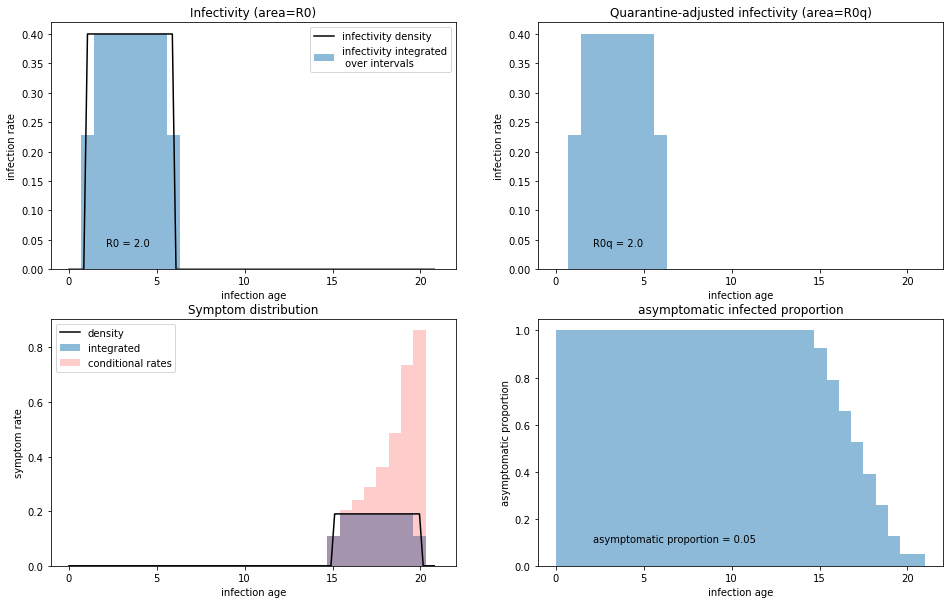

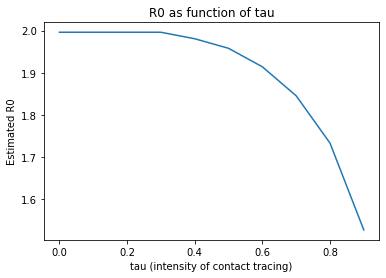

In [2]:
beta_dist=lambda t: 0.4 if 1<=t<=6 else 0
q_dist=lambda t: 0.19 if 15<=t<=20 else 0
N=30
S=simulation(N,beta_dist,q_dist,0.001,policy=lambda S,t:(1,1,0,0),time_scale=21)
_=S.disease_plots()
tau_range=np.arange(0,1,0.1)
R0_range=[]
for tau in tau_range:
    S=simulation(N,beta_dist,q_dist,0.001,policy=lambda S,t:(1,1,0,tau),time_scale=21)
    R0_range.append(S.estimate_R0())
fig,ax=plt.subplots()
ax.plot(tau_range,R0_range)
ax.set_title("R0 as function of tau")
ax.set_xlabel("tau (intensity of contact tracing)")
_=ax.set_ylabel("Estimated R0")

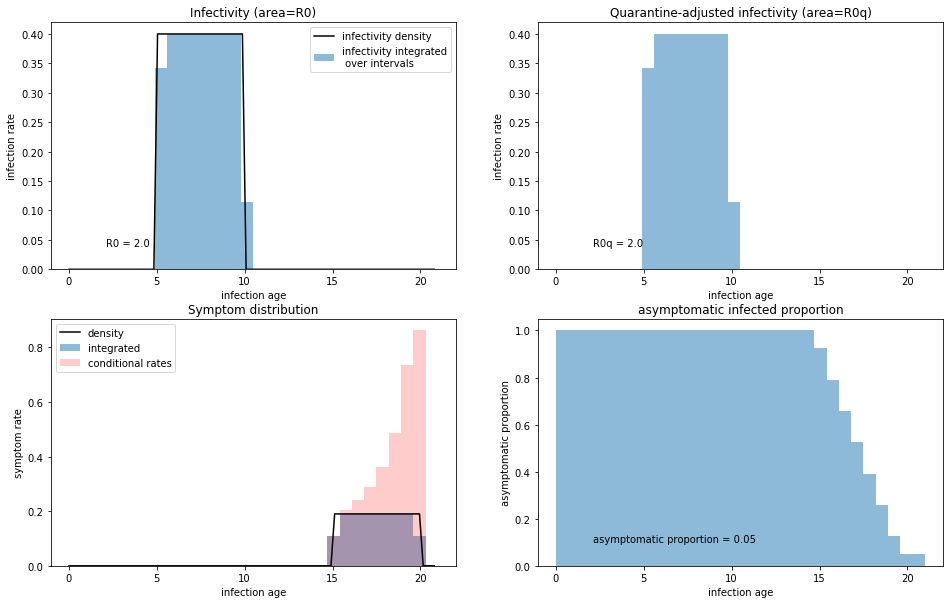

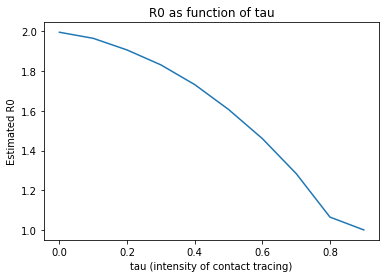

In [3]:
beta_dist=lambda t: 0.4 if 5<=t<=10 else 0
q_dist=lambda t: 0.19 if 15<=t<=20 else 0
N=30
S=simulation(N,beta_dist,q_dist,0.001,policy=lambda S,t:(1,1,0,0),time_scale=21)
_=S.disease_plots()
tau_range=np.arange(0,1,0.1)
R0_range=[]
for tau in tau_range:
    S=simulation(N,beta_dist,q_dist,0.001,policy=lambda S,t:(1,1,0,tau),time_scale=21)
    R0_range.append(S.estimate_R0())
fig,ax=plt.subplots()
ax.plot(tau_range,R0_range)
ax.set_title("R0 as function of tau")
ax.set_xlabel("tau (intensity of contact tracing)")
_=ax.set_ylabel("Estimated R0")

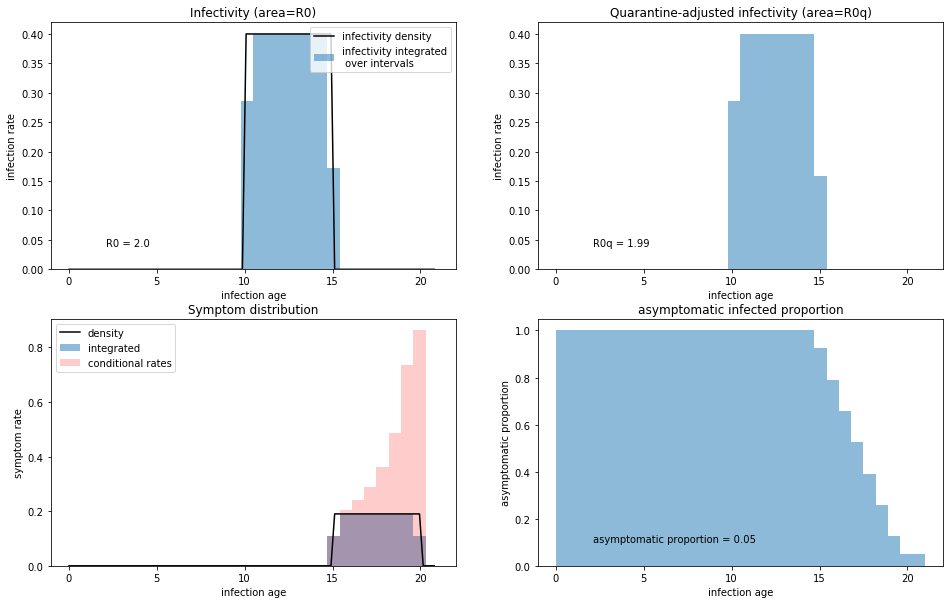

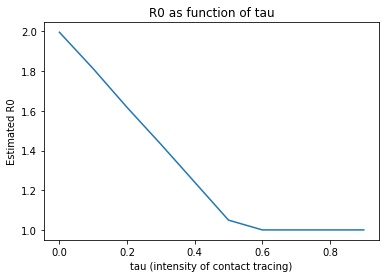

In [4]:
beta_dist=lambda t: 0.4 if 10<=t<=15 else 0
q_dist=lambda t: 0.19 if 15<=t<=20 else 0
N=30
S=simulation(N,beta_dist,q_dist,0.001,policy=lambda S,t:(1,1,0,0),time_scale=21)
_=S.disease_plots()
tau_range=np.arange(0,1,0.1)
R0_range=[]
for tau in tau_range:
    S=simulation(N,beta_dist,q_dist,0.001,policy=lambda S,t:(1,1,0,tau),time_scale=21)
    R0_range.append(S.estimate_R0())
fig,ax=plt.subplots()
ax.plot(tau_range,R0_range)
ax.set_title("R0 as function of tau")
ax.set_xlabel("tau (intensity of contact tracing)")
_=ax.set_ylabel("Estimated R0")